## Clifford Fourier Transform for color images

This code corresponds the implementation described in:
"Color object recognition based on a clifford fourier transform". 
Jose Mennesson, Christophe Saint-Jean, and Laurent Mascarilla. 
In book "Guide to Geometric Algebra in Practice". Springer, 2011.

Python code here is an adaptation of Matlab code by the previous authors.

In [1]:
try:
    import galgebra
except:
    print("[optional] galgebra required for mathematical description")
    
try:
    from scipy.misc import imread
except:
    print("scipy and pillow required for loading & displaying images")

try:
    import requests 
except:
    print("[optional] requests required for downloading images")
    
import io    
import numpy as np  
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from IPython.display import display

print('matplotlib version : ' + matplotlib.__version__ + '(tested with matplotlib 1.5.2)')
print('numpy version : ' + np.__version__ + '(tested with numpy 1.11.1)')
print('ipywidgets version : ' + widgets.__version__ + '(tested with ipywidgets 5.1.5)')


[optional] galgebra required for mathematical description
matplotlib version : 2.1.0(tested with matplotlib 1.5.2)
numpy version : 1.13.3(tested with numpy 1.11.1)
ipywidgets version : 7.0.3(tested with ipywidgets 5.1.5)


### Mathematical description

To be written ...


### Signal processing implementation

In [2]:
## Get Image from file
def image_from_file(filename): 
    return imread(filename)

## Get Image for url
def image_from_url(url):
    return image_from_file(io.BytesIO(requests.get(url).content))

In [4]:
def display_from_url(url):
    plt.figure(0)
    image = image_from_url(url)[:,:,:3]/255.
    plt.imshow(image)
    plt.show()
    
url_examples =['https://hal.archives-ouvertes.fr/hal-00332912v2/file/Fhouse_color.png',
       'http://www.cs.cmu.edu/~chuck/lennapg/lena_std.tif']

url = widgets.Text(value=url_examples[0])
url_box = widgets.Text(description='URL:',value='Enter the URL of your image')
sep_text = widgets.Label(value="\n Or pick among some examples :      ")
b1 = widgets.Button(description='Color Fourier House')
b2 = widgets.Button(description='Lena')
hbox=widgets.HBox(children=(sep_text, b1, b2))
vbox=widgets.VBox(children=(url_box, hbox))
#image = None

def on_click_b1(b):
    url.value = url_examples[0]
    display_from_url(url_examples[0])
    
def on_click_b2(b):
    url.value = url_examples[1]
    display_from_url(url_examples[1])

def on_submit_url(b):
    url.value = b.value
    display_from_url(b.value)
    
url_box.on_submit(on_submit_url)
b1.on_click(on_click_b1)
b2.on_click(on_click_b2)

display(vbox)


VBox(children=(Text(value='Enter the URL of your image', description='URL:'), HBox(children=(Label(value='\n Or pick among some examples :      '), Button(description='Color Fourier House', style=ButtonStyle()), Button(description='Lena', style=ButtonStyle())))))

In [5]:
image_filename = None

if image_filename is None:
    image = image_from_url(url=url.value)
else:
    image = image_from_file(image_filename)

In [6]:
def get_basis(c1, c2 = None):
    c1 /= np.linalg.norm(c1)
    if c2 is None:  
        mu = np.ones(3)
        if np.allclose(np.cross(c1, mu), np.zeros(3)):
            mu = np.array([1.,0.,0.])
        c3 = np.cross(c1,np.cross(mu,c1))
        c3 /= np.linalg.norm(c3)
        c4 = np.cross(c3, c1)
        assert(np.allclose(np.linalg.norm(c4), 1.))
        return np.append(c1,0.), np.array([0,0,0,1.]), np.append(c3,0.), np.append(c4,0.)
    else:
        c3 = np.cross(c1, c2)
        c3 /= np.linalg.norm(c3)
        c2 = -np.cross(c1, c3)
        assert(np.allclose(np.linalg.norm(c2), 1.))
        return np.append(c1,0), np.append(c2,0), np.append(c3,0), np.array([0,0,0,1.])

<IPython.core.display.Javascript object>


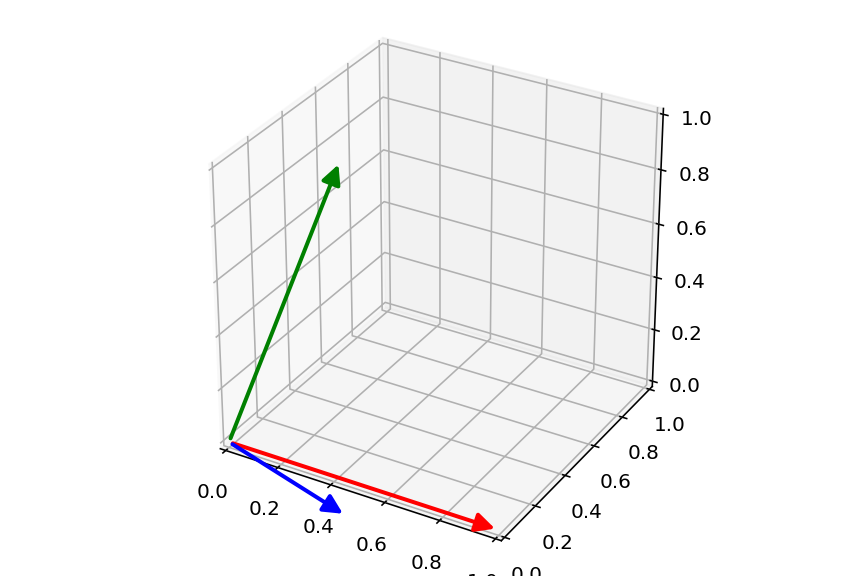

In [8]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        ## renderer.M is the current projection matrix
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def draw_basis(basis, ax=None):
    if ax is None:
        fig = plt.figure(1)
        ax = Axes3D(fig)
    ax.set_aspect("equal")
    a = Arrow3D([0, basis[0][0]], [0, basis[0][1]], [0, basis[0][2]] , mutation_scale=20, lw=2, arrowstyle="-|>", color="r")
    ax.add_artist(a)
    a = Arrow3D([0, basis[2][0]], [0, basis[2][1]], [0, basis[2][2]] , mutation_scale=20, lw=2, arrowstyle="-|>", color="g")
    ax.add_artist(a)
    a = Arrow3D([0, basis[3][0]], [0, basis[3][1]], [0, basis[3][2]] , mutation_scale=20, lw=2, arrowstyle="-|>", color="b")
    ax.add_artist(a)
    return ax

ax = draw_basis(get_basis(np.array([1., 0., 0.])))
plt.draw()
plt.show()

In [9]:
def cfft2(image, basis, reconstruction = False):
    h,l,chan = image.shape
    if chan == 4:
        pass
    elif chan == 3:
        image = np.dstack((image, np.zeros((h,l)))) # add a fourth component with 0
    else:
        raise ValueError
    # Computation of two FFT2s on the two projections of the image
    output = { 'parallel' : np.fft.fft2(np.dot(image, basis[0]) + 1j* np.dot(image, basis[1])),
              'orthogonal': np.fft.fft2(np.dot(image, basis[2]) + 1j *np.dot(image, basis[3]))}
    if reconstruction is True:
        output['reconstruction'] = np.outer(output['parallel'].real,basis[0])
        output['reconstruction'] += np.outer(output['parallel'].imag, basis[1])
        output['reconstruction'] += np.outer(output['orthogonal'].real, basis[2])
        output['reconstruction'] += np.outer(output['orthogonal'].imag, basis[3])
        output['reconstruction'] = np.reshape(output['reconstruction'],(h,l,4))
    return output


In [10]:
def icfft2(tf_image, basis):
    if 'parallel' in tf_image and 'orthogonal' in tf_image:
        h,l = tf_image['parallel'].shape
        _ = np.fft.ifft2(tf_image['parallel'])
        image = np.outer(_.real, basis[0])
        image += np.outer(_.imag, basis[1])
        _ = np.fft.ifft2(tf_image['orthogonal'])
        image += np.outer(_.real, basis[2])
        image += np.outer(_.imag, basis[3])      
    elif 'reconstruction' in tf_image:
        _ = tf_image['reconstruction']
        return icfft2({'parallel' : np.dot(_, basis[0]) + 1j* np.dot(_, basis[1]),
                       'orthogonal' : np.dot(_, basis[2]) + 1j* np.dot(_, basis[3])}, basis)
    elif fft_image.shape[2] == 4:
        return icfft2({'reconstruction' : tf_image}, basis)
    else:
        raise ValueError  
    return np.reshape(image, (h,l,4))

In [11]:
r_slider = widgets.IntSlider(value=255, min=0, max=255, step=1, description='R: ')
g_slider = widgets.IntSlider(value=0, min=0, max=255, step=1, description='G: ')
b_slider = widgets.IntSlider(value=0, min=0, max=255, step=1, description='B: ')


def f(r,g,b):
    basis = get_basis(np.array([r,g,b], dtype=np.double))
    if image is None:
        print('Load an image first ...')
    else:
        R = cfft2(image, basis)
        IR = icfft2(R, basis)
        fig = plt.figure(2, figsize=(9,9))
        
        ax = fig.add_subplot(2, 2, 1)
        ax.imshow(image)
        ax.set_title('Original image')
    
        ax = fig.add_subplot(2, 2, 2, projection='3d')
        ax = draw_basis(basis, ax)
        ax.set_title('Basis')
    
        ax = fig.add_subplot(2, 2, 3)
        ax.imshow(np.log(1+np.abs(np.fft.fftshift(R['parallel']))), plt.cm.Blues)
        ax.set_title('Spectrum in first basis (parallel)')
    
        ax = fig.add_subplot(2, 2, 4)
        ax.imshow(np.log(1+np.abs(np.fft.fftshift(R['orthogonal']))), plt.cm.Blues)
        ax.set_title('Spectrum in second basis (orthogonal)')
              
w = widgets.interactive(f, r=r_slider, g=g_slider, b=b_slider)
display(w)

interactive(children=(IntSlider(value=255, description='R: ', max=255), IntSlider(value=0, description='G: ', max=255), IntSlider(value=0, description='B: ', max=255), Output()), _dom_classes=('widget-interact',))

### Speed considerations

In [10]:
basis = get_basis(np.array([1,0,0], dtype=np.double))
%timeit icfft2(cfft2(image, basis), basis)

100 loops, best of 3: 19.3 ms per loop
